## Preprocessing

### Create data for training 

In [6]:
from sklearn.datasets import make_blobs
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
def create_instances(n_samples_,centers_):
  features, clusters = make_blobs(n_samples=n_samples_,n_features=2,centers=centers_, cluster_std=2,shuffle=True,center_box=(0,100))
  # features=np.insert(features,0,[np.random.randint(0,100),np.random.randint(0,100)],axis=0)
  features=np.insert(features,0,(40,50),axis=0)
  # print()
  # print('Feature Matrix:');
  # print(pd.DataFrame(features,columns=np.arange(1,3)).head())
  return features

In [8]:
features=create_instances(31,4)

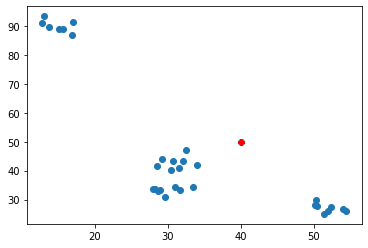

In [9]:
plt.scatter(features[:,0],features[:,1])
plt.scatter(features[0,0],features[0,1],marker='P',color='red')

In [10]:
import torch
num_instances_=10000
n_samples_=30
n_centers=4
x=[]
y=[]
for i in range(num_instances_):
  features=create_instances(n_samples_,n_centers)
  x.append(features[:,0])
  y.append(features[:,1])
x=torch.tensor(x,dtype=torch.float32).view(num_instances_,1,-1)
y=torch.tensor(y,dtype=torch.float32).view(num_instances_,1,-1)
tuple=(x,y)
xy=torch.torch.cat(tuple,dim=1)
xy.size()


torch.Size([10000, 2, 31])

### Preprocess Benchmarck Datasets

In [11]:
import numpy as np
import pandas as pd
# Import BeautifulSoup
from bs4 import BeautifulSoup as bs
from os import listdir
import torch

# Class that process all the datasets to coordinates and demand array (batch x 2 x nodes)
class Preprocess:
    def __init__(self,paths_:str):
        self.paths_=paths_
        self.Filenames=[]        
        self.dataset={}
        # xy={'cx':[],'cy':[]}
        
        # self.dem=[]
   # Extract the files names   
    def listFiles (self):
        for file in listdir(self.paths_):
            self.Filenames.append('./Datasets/data/'+file)
        return self.Filenames
    # Extract the Coordinates cx and cy and demand in arrays
    def processFiles (name_path,criteria):
        content = []
        xy={'cx':[],'cy':[]}
        dem=[]
        if criteria in name_path:
            with open (name_path,'r') as file:
                content=file.readlines()
                content="".join(content)
                bs_content=bs(content,'xml')
            
            for nodes in bs_content.find_all('nodes'):
                for node_ in nodes.find_all('node'):

                    for text in node_.find_all('cx'):
                        xy['cx'].append(text.text)

                    for text in node_.find_all('cy'):
                        xy['cy'].append(text.text)
          
            dem.append(0.)  
            for request in bs_content.find_all('quantity'):
                dem.append(float(request.text))

            return xy, dem   
    # Process each file 
    def create(self,num_nodes_):
        myListName=self.listFiles()
       
        for name in myListName:
            _=self.processFiles(name_path=name,criteria=num_nodes_)
            
        return self.xy,self.dem
        


### Reshape data

In [12]:
from sklearn import preprocessing
num_instances=1
# dataset=Preprocess(paths_='./Datasets/data/')
a,b=Preprocess.processFiles('./Datasets/data/E-n101-k08.xml','08')
# a,b=Preprocess.processFiles('C1_02_01.xml','200')
coor=pd.DataFrame.from_dict(a,dtype=float).values.T
dem=np.array(b,dtype=float).reshape(num_instances,1,-1)
coor1=coor.reshape(num_instances,2,-1)

# Normalization
# min_max_scaler = preprocessing.MinMaxScaler()
# coor_normalize=min_max_scaler.fit_transform(coor).reshape(num_instances,2,-1)

# Convert to tensor
# coor_normalize=torch.tensor(coor_normalize,dtype=torch.float32)
coor_normalize=np.hsplit(coor,num_instances)
coor_normalize=torch.tensor(coor_normalize,dtype=torch.float32)
dem=torch.tensor(dem,dtype=int)

print(coor_normalize)
print(dem)

tensor([[[35., 41., 35., 55., 55., 15., 25., 20., 10., 55., 30., 20., 50., 30.,
          15., 30., 10.,  5., 20., 15., 45., 45., 45., 55., 65., 65., 45., 35.,
          41., 64., 40., 31., 35., 53., 65., 63.,  2., 20.,  5., 60., 40., 42.,
          24., 23., 11.,  6.,  2.,  8., 13.,  6., 47., 49., 27., 37., 57., 63.,
          53., 32., 36., 21., 17., 12., 24., 27., 15., 62., 49., 67., 56., 37.,
          37., 57., 47., 44., 46., 49., 49., 53., 61., 57., 56., 55., 15., 14.,
          11., 16.,  4., 28., 26., 26., 31., 15., 22., 18., 26., 25., 22., 25.,
          19., 20., 18.],
         [35., 49., 17., 45., 20., 30., 30., 50., 43., 60., 60., 65., 35., 25.,
          10.,  5., 20., 30., 40., 60., 65., 20., 10.,  5., 35., 20., 30., 40.,
          37., 42., 60., 52., 69., 52., 55., 65., 60., 20.,  5., 12., 25.,  7.,
          12.,  3., 14., 38., 48., 56., 52., 68., 47., 58., 43., 31., 29., 23.,
          12., 12., 26., 24., 34., 24., 58., 69., 77., 77., 73.,  5., 39., 47.,
          56.,

### Plot coordinates instance

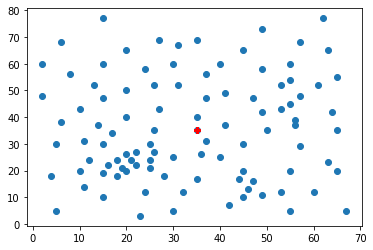

In [13]:
import matplotlib.pyplot as plt

x=coor_normalize[0,0]
y=coor_normalize[0,1]
plt.scatter(x,y)
plt.scatter(x[0],y[0],marker='P',color='red')


In [14]:
print('Depot coordinate',coor_normalize[0,0,0],coor_normalize[0,1,0])

Depot coordinate tensor(35.) tensor(35.)


### Create dataset 

In [15]:
"""Defines the main task for the PRP.

The PRP is defined by the following traits:
    1. Each city has a demand in [1, 40], which must be serviced by the vehicle
    2. Each vehicle has a capacity (depends on problem), the must visit all cities
    3. When the vehicle load is 0, it __must__ return to the depot to refill
"""

import os
import numpy as np
# import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import warnings


class VehicleRoutingDataset(Dataset):
    def __init__(self, num_instances_, input_size, max_load=700, max_demand=50,
                 seed=None):
        super(VehicleRoutingDataset, self).__init__()

        # if max_load < max_demand:
        #     raise ValueError(':param max_load: must be > max_demand')

        if seed is None:
            seed = np.random.randint(1234567890)
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.num_instances=num_instances_
        self.max_load = max_load
        self.max_demand = max_demand

        # Depot location will be the first node in each
        locations = xy
        self.static = locations

        # All states will broadcast the drivers current load
        # Note that we only use a load between [0, 1] to prevent large
        # numbers entering the neural network
        dynamic_shape = (num_instances, 1, input_size + 1)
        loads = torch.full(dynamic_shape, 1.)

        # All states will have their own intrinsic demand in [1, max_demand), 
        # then scaled by the maximum load. E.g. if load=10 and max_demand=30, 
        # demands will be scaled to the range (0, 3)
        demands = torch.randint(1, max_demand + 1, dynamic_shape)
        demands = demands / float(max_load)

        demands[:, 0, 0] = 0  # depot starts with a demand of 0
        self.dynamic = torch.tensor(np.concatenate((loads, demands), axis=1))
        

    def __len__(self):
        return self.num_instances

    def __getitem__(self, idx):
        # (static, dynamic, start_loc)
        return (self.static[idx], self.dynamic[idx], self.static[idx, :, 0:1])

    def update_mask(self, mask, dynamic, chosen_idx=None):
        """Updates the mask used to hide non-valid states.

        Parameters
        ----------
        dynamic: torch.autograd.Variable of size (1, num_feats, seq_len)
        """

        # Convert floating point to integers for calculations
        loads = dynamic.data[:, 0]  # (batch_size, seq_len)
        demands = dynamic.data[:, 1]  # (batch_size, seq_len)

        # If there is no positive demand left, we can end the tour.
        # Note that the first node is the depot, which always has a negative demand
        if demands.eq(0).all():
            return demands * 0.

        # Otherwise, we can choose to go anywhere where demand is > 0
        new_mask = demands.ne(0) * demands.lt(loads)

        # We should avoid traveling to the depot back-to-back
        repeat_home = chosen_idx.ne(0)

        if repeat_home.any():
            new_mask[repeat_home.nonzero(), 0] = 1.
        if ~repeat_home.any():
            new_mask[~repeat_home.nonzero(), 0] = 0.

        # ... unless we're waiting for all other samples in a minibatch to finish
        has_no_load = loads[:, 0].eq(0).float()
        has_no_demand = demands[:, 1:].sum(1).eq(0).float()

        combined = (has_no_load + has_no_demand).gt(0)
        if combined.any():
            new_mask[combined.nonzero(), 0] = 1.
            new_mask[combined.nonzero(), 1:] = 0.

        return new_mask.float()

    def update_dynamic(self, dynamic, chosen_idx):
        """Updates the (load, demand) dataset values."""

        # Update the dynamic elements differently for if we visit depot vs. a city
        visit = chosen_idx.ne(0)
        depot = chosen_idx.eq(0)

        # Clone the dynamic variable so we don't mess up graph
        all_loads = dynamic[:, 0].clone()
        all_demands = dynamic[:, 1].clone()

        load = torch.gather(all_loads, 1, chosen_idx.unsqueeze(1))
        demand = torch.gather(all_demands, 1, chosen_idx.unsqueeze(1))

        # Across the minibatch - if we've chosen to visit a city, try to satisfy
        # as much demand as possible
        if visit.any():

            new_load = torch.clamp(load - demand, min=0)
            new_demand = torch.clamp(demand - load, min=0)

            # Broadcast the load to all nodes, but update demand seperately
            visit_idx = visit.nonzero().squeeze()

            all_loads[visit_idx] = new_load[visit_idx]
            all_demands[visit_idx, chosen_idx[visit_idx]] = new_demand[visit_idx].view(-1)
            all_demands[visit_idx, 0] = -1. + new_load[visit_idx].view(-1)

        # Return to depot to fill vehicle load
        if depot.any():
            all_loads[depot.nonzero().squeeze()] = 1.
            all_demands[depot.nonzero().squeeze(), 0] = 0.

        tensor = torch.cat((all_loads.unsqueeze(1), all_demands.unsqueeze(1)), 1)
        # return torch.tensor(tensor.data, device=dynamic.device)
    
        return tensor.clone().detach()
        

    

        

    


In [16]:
"""Defines the main task for the PRP.

The PRP is defined by the following traits:
    1. Each city has a demand in [1, 9], which must be serviced by the vehicle
    2. Each vehicle has a capacity (depends on problem), the must visit all cities
    3. When the vehicle load is 0, it __must__ return to the depot to refill
"""

import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import warnings


class VehicleRoutingDataset1(Dataset):
    def __init__(self, num_instances, max_load=700,
                 seed=None):
        super(VehicleRoutingDataset1, self).__init__()


        if seed is None:
            seed = np.random.randint(1234567890)
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.num_instances = num_instances
        self.max_load = max_load
    


        # Depot location will be the first node in each
        locations = coor_normalize
        self.static = locations

        # All states will broadcast the drivers current load
        # Note that we only use a load between [0, 1] to prevent large
        # numbers entering the neural network
        dynamic_shape = (num_instances, 1, args.num_nodes + 1)
        loads = torch.full(dynamic_shape, 1.)

        # All states will have their own intrinsic demand in [1, max_demand), 
        # then scaled by the maximum load. E.g. if load=10 and max_demand=30, 
        # demands will be scaled to the range (0, 3)
        demands = dem
        demands = demands / float(max_load)

        demands[:, 0, 0] = 0  # depot starts with a demand of 0
        self.dynamic = torch.tensor(np.concatenate((loads, demands), axis=1))

        

    def __len__(self):
        return self.num_instances

    def __getitem__(self, idx):
        # (static, dynamic, start_loc)
        return (self.static[idx], self.dynamic[idx], self.static[idx, :, 0:1])

    def update_mask(self, mask, dynamic, chosen_idx=None):
        """Updates the mask used to hide non-valid states.

        Parameters
        ----------
        dynamic: torch.autograd.Variable of size (1, num_feats, seq_len)
        """

        # Convert floating point to integers for calculations
        loads = dynamic.data[:, 0]  # (batch_size, seq_len)
        demands = dynamic.data[:, 1]  # (batch_size, seq_len)

        # If there is no positive demand left, we can end the tour.
        # Note that the first node is the depot, which always has a negative demand
        if demands.eq(0).all():
            return demands * 0.

        # Otherwise, we can choose to go anywhere where demand is > 0
        new_mask = demands.ne(0) * demands.lt(loads)

        # We should avoid traveling to the depot back-to-back
        repeat_home = chosen_idx.ne(0)

        if repeat_home.any():
            new_mask[repeat_home.nonzero(), 0] = 1.
        if ~repeat_home.any():
            new_mask[~repeat_home.nonzero(), 0] = 0.

        # ... unless we're waiting for all other samples in a minibatch to finish
        has_no_load = loads[:, 0].eq(0).float()
        has_no_demand = demands[:, 1:].sum(1).eq(0).float()

        combined = (has_no_load + has_no_demand).gt(0)
        if combined.any():
            new_mask[combined.nonzero(), 0] = 1.
            new_mask[combined.nonzero(), 1:] = 0.

        return new_mask.float()

    def update_dynamic(self, dynamic, chosen_idx):
        """Updates the (load, demand) dataset values."""

        # Update the dynamic elements differently for if we visit depot vs. a city
        visit = chosen_idx.ne(0)
        depot = chosen_idx.eq(0)

        # Clone the dynamic variable so we don't mess up graph
        all_loads = dynamic[:, 0].clone()
        all_demands = dynamic[:, 1].clone()

        load = torch.gather(all_loads, 1, chosen_idx.unsqueeze(1))
        demand = torch.gather(all_demands, 1, chosen_idx.unsqueeze(1))

        # Across the minibatch - if we've chosen to visit a city, try to satisfy
        # as much demand as possible
        if visit.any():

            new_load = torch.clamp(load - demand, min=0)
            new_demand = torch.clamp(demand - load, min=0)

            # Broadcast the load to all nodes, but update demand seperately
            visit_idx = visit.nonzero().squeeze()

            all_loads[visit_idx] = new_load[visit_idx]
            all_demands[visit_idx, chosen_idx[visit_idx]] = new_demand[visit_idx].view(-1)
            all_demands[visit_idx, 0] = -1. + new_load[visit_idx].view(-1)

        # Return to depot to fill vehicle load
        if depot.any():
            all_loads[depot.nonzero().squeeze()] = 1.
            all_demands[depot.nonzero().squeeze(), 0] = 0.

        tensor = torch.cat((all_loads.unsqueeze(1), all_demands.unsqueeze(1)), 1)
        # return torch.tensor(tensor.data, device=dynamic.device)
        
        return tensor.clone().detach()

    

### Reward Function

In [17]:

def reward(static,dynamic, tour_indices):
    """
    Euclidean distance between all cities / nodes given by tour_indices
    """

    # Convert the indices back into a tour
    idx = tour_indices.unsqueeze(1).expand(-1, static.size(1), -1)
    tour = torch.gather(static.data, 2, idx).permute(0, 2, 1)
    tour_weight=torch.gather(dynamic.data,2,idx).permute(0,2,1)


    # Ensure we're always returning to the depot - note the extra concat
    # won't add any extra loss, as the euclidean distance between consecutive
    # points is 0
    start = static.data[:, :, 0].unsqueeze(1)
    y = torch.cat((start, tour, start), dim=1)
    
    
    weight=torch.sum(tour_weight[:,0].unsqueeze(1))/args.num_nodes
   

    

    # Euclidean distance between each consecutive point
    tour_len = 2.664*((torch.sqrt(torch.sum(torch.pow(y[:, :-1] - y[:, 1:], 2), dim=2))*(0.0635+0.005*weight)))
    # tour_len = torch.sqrt(torch.sum(torch.pow(y[:, :-1] - y[:, 1:], 2), dim=2))


    return tour_len.sum(1)

### Render function

In [18]:

def render(static, tour_indices, save_path):
    """Plots the found solution."""

    plt.close('all')

    num_plots = 1 if int(np.sqrt(len(tour_indices))) >= 3 else 1

    _, axes = plt.subplots(nrows=num_plots, ncols=num_plots,
                           sharex='col', sharey='row')

    if num_plots == 1:
        axes = [[axes]]
    axes = [a for ax in axes for a in ax]

    for i, ax in enumerate(axes):

        # Convert the indices back into a tour
        idx = tour_indices[i]
        if len(idx.size()) == 1:
            idx = idx.unsqueeze(0)

        idx = idx.expand(static.size(1), -1)
        data = torch.gather(static[i].data, 1, idx).cpu().numpy()

        start = static[i, :, 0].cpu().data.numpy()
        x = np.hstack((start[0], data[0], start[0]))
        y = np.hstack((start[1], data[1], start[1]))

        # Assign each subtour a different colour & label in order traveled
        idx = np.hstack((0, tour_indices[i].cpu().numpy().flatten(), 0))
        where = np.where(idx == 0)[0]

        for j in range(len(where) - 1):

            low = where[j]
            high = where[j + 1]

            if low + 1 == high:
                continue

            ax.plot(x[low: high + 1], y[low: high + 1], zorder=1, label=j)

        ax.legend(loc="upper right", fontsize=3, framealpha=0.5)
        ax.scatter(x, y, s=4, c='b', zorder=2)
        ax.scatter(x[0], y[0], s=20, c='k', marker='P', zorder=3)

        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)



# def render(static, tour_indices, save_path):
#     """Plots the found solution."""

#     path = './data/'
#     plt.rcParams['animation.ffmpeg_path'] = path

#     plt.close('all')

#     num_plots = min(int(np.sqrt(len(tour_indices))), 3)
#     fig, axes = plt.subplots(nrows=num_plots, ncols=num_plots,
#                              sharex='col', sharey='row')
#     axes = [a for ax in axes for a in ax]

#     all_lines = []
#     all_tours = []
#     for i, ax in enumerate(axes):

#         # Convert the indices back into a tour
#         idx = tour_indices[i]
#         if len(idx.size()) == 1:
#             idx = idx.unsqueeze(0)

#         idx = idx.expand(static.size(1), -1)
#         data = torch.gather(static[i].data, 1, idx).cpu().numpy()

#         start = static[i, :, 0].cpu().data.numpy()
#         x = np.hstack((start[0], data[0], start[0]))
#         y = np.hstack((start[1], data[1], start[1]))

#         cur_tour = np.vstack((x, y))

#         all_tours.append(cur_tour)
#         all_lines.append(ax.plot([], [])[0])

#         ax.scatter(x, y, s=4, c='r', zorder=2)
#         ax.scatter(x[0], y[0], s=20, c='k', marker='*', zorder=3)

#     from matplotlib.animation import FuncAnimation

#     tours = all_tours

#     def update(idx):

#         for i, line in enumerate(all_lines):

#             if idx >= tours[i].shape[1]:
#                 continue

#             data = tours[i][:, idx]

#             xy_data = line.get_xydata()
#             xy_data = np.vstack((xy_data, np.atleast_2d(data)))

#             line.set_data(xy_data[:, 0], xy_data[:, 1])
#             line.set_linewidth(0.75)

#         return all_lines

#     anim = FuncAnimation(fig, update, init_func=None,
#                          frames=100, interval=200, blit=False,
#                          repeat=False)

#     anim.save('line.mp4', dpi=160)
#     plt.show()

#     import sys
#     sys.exit(1)

### Encoder - Decoder - Attention

In [19]:
# import torch
import torch.nn as nn
import torch.nn.functional as F

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')


class Encoder(nn.Module):
    """Encodes the static & dynamic states using 1d Convolution."""

    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(input_size, hidden_size, kernel_size=1)

    def forward(self, input):
        output = self.conv(input)
        return output  # (batch, hidden_size, seq_len)


class Attention(nn.Module):
    """Calculates attention over the input nodes given the current state."""

    def __init__(self, hidden_size):
        super(Attention, self).__init__()

        # W processes features from static decoder elements
        self.v = nn.Parameter(torch.zeros((1, 1, hidden_size),
                                          device=device, requires_grad=True))

        self.W = nn.Parameter(torch.zeros((1, hidden_size, 3 * hidden_size),
                                          device=device, requires_grad=True))

    def forward(self, static_hidden, dynamic_hidden, decoder_hidden):

        batch_size, hidden_size, _ = static_hidden.size()

        hidden = decoder_hidden.unsqueeze(2).expand_as(static_hidden)
        hidden = torch.cat((static_hidden, dynamic_hidden, hidden), 1)

        # Broadcast some dimensions so we can do batch-matrix-multiply
        v = self.v.expand(batch_size, 1, hidden_size)
        W = self.W.expand(batch_size, hidden_size, -1)

        attns = torch.bmm(v, torch.tanh(torch.bmm(W, hidden)))
        attns = F.softmax(attns, dim=2)  # (batch, seq_len)
        return attns


class Pointer(nn.Module):
    """Calculates the next state given the previous state and input embeddings."""

    def __init__(self, hidden_size, num_layers=1, dropout=0.2):
        super(Pointer, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Used to calculate probability of selecting next state
        self.v = nn.Parameter(torch.zeros((1, 1, hidden_size),
                                          device=device, requires_grad=True))

        self.W = nn.Parameter(torch.zeros((1, hidden_size, 2 * hidden_size),
                                          device=device, requires_grad=True))

        # Used to compute a representation of the current decoder output
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers,
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0)
        self.encoder_attn = Attention(hidden_size)

        self.drop_rnn = nn.Dropout(p=dropout)
        self.drop_hh = nn.Dropout(p=dropout)

    def forward(self, static_hidden, dynamic_hidden, decoder_hidden, last_hh):

        rnn_out, last_hh = self.gru(decoder_hidden.transpose(2, 1), last_hh)
        rnn_out = rnn_out.squeeze(1)

        # Always apply dropout on the RNN output
        rnn_out = self.drop_rnn(rnn_out)
        if self.num_layers == 1:
            # If > 1 layer dropout is already applied
            last_hh = self.drop_hh(last_hh) 

        # Given a summary of the output, find an  input context
        enc_attn = self.encoder_attn(static_hidden, dynamic_hidden, rnn_out)
        context = enc_attn.bmm(static_hidden.permute(0, 2, 1))  # (B, 1, num_feats)

        # Calculate the next output using Batch-matrix-multiply ops
        context = context.transpose(1, 2).expand_as(static_hidden)
        energy = torch.cat((static_hidden, context), dim=1)  # (B, num_feats, seq_len)

        v = self.v.expand(static_hidden.size(0), -1, -1)
        W = self.W.expand(static_hidden.size(0), -1, -1)

        probs = torch.bmm(v, torch.tanh(torch.bmm(W, energy))).squeeze(1)

        return probs, last_hh


### Actor

In [20]:
class DRL4TSP(nn.Module):
    """Defines the main Encoder, Decoder, and Pointer combinatorial models.

    Parameters
    ----------
    static_size: int
        Defines how many features are in the static elements of the model
        (e.g. 2 for (x, y) coordinates)
    dynamic_size: int > 1
        Defines how many features are in the dynamic elements of the model
        (e.g. 2 for the PRP which has (load, demand) attributes. The TSP doesn't
        have dynamic elements, but to ensure compatility with other optimization
        problems, assume we just pass in a vector of zeros.
    hidden_size: int
        Defines the number of units in the hidden layer for all static, dynamic,
        and decoder output units.
    update_fn: function or None
        If provided, this method is used to calculate how the input dynamic
        elements are updated, and is called after each 'point' to the input element.
    mask_fn: function or None
        Allows us to specify which elements of the input sequence are allowed to
        be selected. This is useful for speeding up training of the networks,
        by providing a sort of 'rules' guidlines to the algorithm. If no mask
        is provided, we terminate the search after a fixed number of iterations
        to avoid tours that stretch forever
    num_layers: int
        Specifies the number of hidden layers to use in the decoder RNN
    dropout: float
        Defines the dropout rate for the decoder
    """

    def __init__(self, static_size, dynamic_size, hidden_size,
                 update_fn=None, mask_fn=None, num_layers=1, dropout=0.):
        super(DRL4TSP, self).__init__()

        if dynamic_size < 1:
            raise ValueError(':param dynamic_size: must be > 0, even if the '
                             'problem has no dynamic elements')

        self.update_fn = update_fn
        self.mask_fn = mask_fn

        # Define the encoder & decoder models
        self.static_encoder = Encoder(static_size, hidden_size)
        self.dynamic_encoder = Encoder(dynamic_size, hidden_size)
        self.decoder = Encoder(static_size, hidden_size)
        self.pointer = Pointer(hidden_size, num_layers, dropout)

        for p in self.parameters():
            if len(p.shape) > 1:
                nn.init.xavier_uniform_(p)

        # Used as a proxy initial state in the decoder when not specified
        self.x0 = torch.zeros((1, static_size, 1), requires_grad=True, device=device)

    def forward(self, static, dynamic, decoder_input=None, last_hh=None):
        """
        Parameters
        ----------
        static: Array of size (batch_size, feats, num_cities)
            Defines the elements to consider as static. For the TSP, this could be
            things like the (x, y) coordinates, which won't change
        dynamic: Array of size (batch_size, feats, num_cities)
            Defines the elements to consider as static. For the PRP, this can be
            things like the (load, demand) of each city. If there are no dynamic
            elements, this can be set to None
        decoder_input: Array of size (batch_size, num_feats)
            Defines the outputs for the decoder. Currently, we just use the
            static elements (e.g. (x, y) coordinates), but this can technically
            be other things as well
        last_hh: Array of size (batch_size, num_hidden)
            Defines the last hidden state for the RNN
        """

        batch_size, input_size, sequence_size = static.size()

        if decoder_input is None:
            decoder_input = self.x0.expand(batch_size, -1, -1)

        # Always use a mask - if no function is provided, we don't update it
        mask = torch.ones(batch_size, sequence_size, device=device)

        # Structures for holding the output sequences
        tour_idx, tour_logp = [], []
        max_steps = sequence_size if self.mask_fn is None else 1000

        # Static elements only need to be processed once, and can be used across
        # all 'pointing' iterations. When / if the dynamic elements change,
        # their representations will need to get calculated again.
        static_hidden = self.static_encoder(static)
        dynamic_hidden = self.dynamic_encoder(dynamic)

        for _ in range(max_steps):

            if not mask.byte().any():
                break

            # ... but compute a hidden rep for each element added to sequence
            decoder_hidden = self.decoder(decoder_input)

            probs, last_hh = self.pointer(static_hidden,
                                          dynamic_hidden,
                                          decoder_hidden, last_hh)
            probs = F.softmax(probs + mask.log(), dim=1)

            # When training, sample the next step according to its probability.
            # During testing, we can take the greedy approach and choose highest
            if self.training:
                m = torch.distributions.Categorical(probs)

                # Sometimes an issue with Categorical & sampling on GPU; See:
                # https://github.com/pemami4911/neural-combinatorial-rl-pytorch/issues/5
                ptr = m.sample()
                while not torch.gather(mask, 1, ptr.data.unsqueeze(1)).byte().all():
                    ptr = m.sample()
                logp = m.log_prob(ptr)
            else:
                prob, ptr = torch.max(probs, 1)  # Greedy
                logp = prob.log()

            # After visiting a node update the dynamic representation
            if self.update_fn is not None:
                dynamic = self.update_fn(dynamic, ptr.data)
                dynamic_hidden = self.dynamic_encoder(dynamic)

                # Since we compute the PRP in minibatches, some tours may have
                # number of stops. We force the vehicles to remain at the depot 
                # in these cases, and logp := 0
                is_done = dynamic[:, 1].sum(1).eq(0).float()
                logp = logp * (1. - is_done)

            # And update the mask so we don't re-visit if we don't need to
            if self.mask_fn is not None:
                mask = self.mask_fn(mask, dynamic, ptr.data).detach()

            tour_logp.append(logp.unsqueeze(1))
            tour_idx.append(ptr.data.unsqueeze(1))

            decoder_input = torch.gather(static, 2,
                                         ptr.view(-1, 1, 1)
                                         .expand(-1, input_size, 1)).detach()

        tour_idx = torch.cat(tour_idx, dim=1)  # (batch_size, seq_len)
        tour_logp = torch.cat(tour_logp, dim=1)  # (batch_size, seq_len)

        return tour_idx, tour_logp


# if __name__ == '__main__':
#     raise Exception('Cannot be called from main')
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    

### Critic

In [21]:
"""Defines the main trainer model for combinatorial problems

Each task must define the following functions:
* mask_fn: can be None
* update_fn: can be None
* reward_fn: specifies the quality of found solutions
* render_fn: Specifies how to plot found solutions. Can be None
"""

import os
import time
import argparse
import datetime
import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# from model import DRL4TSP, Encoder

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')


class StateCritic(nn.Module):
    """Estimates the problem complexity.

    This is a basic module that just looks at the log-probabilities predicted by
    the encoder + decoder, and returns an estimate of complexity
    """

    def __init__(self, static_size, dynamic_size, hidden_size):
        super(StateCritic, self).__init__()

        self.static_encoder = Encoder(static_size, hidden_size)
        self.dynamic_encoder = Encoder(dynamic_size, hidden_size)

        # Define the encoder & decoder models
        self.fc1 = nn.Conv1d(hidden_size * 2, 20, kernel_size=1)
        self.fc2 = nn.Conv1d(20, 20, kernel_size=1)
        self.fc3 = nn.Conv1d(20, 1, kernel_size=1)

        for p in self.parameters():
            if len(p.shape) > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, static, dynamic):

        # Use the probabilities of visiting each
        static_hidden = self.static_encoder(static)
        dynamic_hidden = self.dynamic_encoder(dynamic)

        hidden = torch.cat((static_hidden, dynamic_hidden), 1)

        output = F.relu(self.fc1(hidden))
        output = F.relu(self.fc2(output))
        output = self.fc3(output).sum(dim=2)
        return output


class Critic(nn.Module):
    """Estimates the problem complexity.

    This is a basic module that just looks at the log-probabilities predicted by
    the encoder + decoder, and returns an estimate of complexity
    """

    def __init__(self, hidden_size):
        super(Critic, self).__init__()

        # Define the encoder & decoder models
        self.fc1 = nn.Conv1d(1, hidden_size, kernel_size=1)
        self.fc2 = nn.Conv1d(hidden_size, 20, kernel_size=1)
        self.fc3 = nn.Conv1d(20, 1, kernel_size=1)

        for p in self.parameters():
            if len(p.shape) > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, input):

        output = F.relu(self.fc1(input.unsqueeze(1)))
        output = F.relu(self.fc2(output)).squeeze(2)
        output = self.fc3(output).sum(dim=2)
        return output


### Validate Function

In [22]:

def validate(data_loader, actor, reward_fn, render_fn=None, save_dir='.',
             num_plot=5):
    """Used to monitor progress on a validation set & optionally plot solution."""

    actor.eval()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    rewards = []
    for batch_idx, batch in enumerate(data_loader):

        static, dynamic, x0 = batch

        static = static.to(device)
        dynamic = dynamic.to(device)
        x0 = x0.to(device) if len(x0) > 0 else None

        with torch.no_grad():
            tour_indices, _ = actor.forward(static, dynamic, x0)

        reward = reward_fn(static,dynamic, tour_indices).mean().item()
        rewards.append(reward)

        if render_fn is not None and batch_idx < num_plot:
            name = 'batch%d_%2.4f.png'%(batch_idx, reward)
            path = os.path.join(save_dir, name)
            render_fn(static, tour_indices, path)
        
    

    actor.train()
    return np.mean(rewards)


### Train Function

In [23]:


def train(actor, critic, task, num_nodes, train_data, valid_data, reward_fn,
          render_fn, batch_size, actor_lr, critic_lr, max_grad_norm,
          **kwargs):
    """Constructs the main actor & critic networks, and performs all training."""

    now = '%s' % datetime.datetime.now().time()
    now = now.replace(':', '_')
    save_dir = os.path.join(task, '%d' % num_nodes, now)

    checkpoint_dir = os.path.join(save_dir, 'checkpoints')
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    actor_optim = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optim = optim.Adam(critic.parameters(), lr=critic_lr)

    train_loader = DataLoader(train_data, batch_size, True, num_workers=0)
    valid_loader = DataLoader(valid_data, batch_size, False, num_workers=0)

    best_params = None
    best_reward = np.inf

    for epoch in range(1000):

        actor.train()
        critic.train()

        times, losses, rewards, critic_rewards = [], [], [], []

        epoch_start = time.time()
        start = epoch_start

        for batch_idx, batch in enumerate(train_loader):

            static, dynamic, x0 = batch

            static = static.to(device)
            dynamic = dynamic.to(device)
            x0 = x0.to(device) if len(x0) > 0 else None

            # Full forward pass through the dataset
            tour_indices, tour_logp = actor(static, dynamic, x0)

            # Sum the log probabilities for each city in the tour
            reward = reward_fn(static,dynamic, tour_indices)

            # Query the critic for an estimate of the reward
            critic_est = critic(static, dynamic).view(-1)

            advantage = (reward - critic_est)
            actor_loss = torch.mean(advantage.detach() * tour_logp.sum(dim=1))
            critic_loss = torch.mean(advantage ** 2)

            actor_optim.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), max_grad_norm)
            actor_optim.step()

            critic_optim.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_grad_norm)
            critic_optim.step()

            critic_rewards.append(torch.mean(critic_est.detach()).item())
            rewards.append(torch.mean(reward.detach()).item())
            losses.append(torch.mean(actor_loss.detach()).item())

            if (batch_idx + 1) % 100 == 0:
                end = time.time()
                times.append(end - start)
                start = end

                mean_loss = np.mean(losses[-100:])
                mean_reward = np.mean(rewards[-100:])

                print('  Batch %d/%d, reward: %2.3f, loss: %2.4f, took: %2.4fs' %
                      (batch_idx, len(train_loader), mean_reward, mean_loss,
                       times[-1]))
                writer.add_scalar('Training loss',mean_loss,batch_idx+1)
                writer.add_scalar('Training reward',mean_reward,batch_idx+1)
                

        mean_loss = np.mean(losses)
        mean_reward = np.mean(rewards)
        # mean_times=np.mean(times)
   
        writer.close()

        # Save the weights
        epoch_dir = os.path.join(checkpoint_dir, '%s' % epoch)
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)

        save_path = os.path.join(epoch_dir, 'actor.pt')
        torch.save(actor.state_dict(), save_path)

        save_path = os.path.join(epoch_dir, 'critic.pt')
        torch.save(critic.state_dict(), save_path)

        # Save rendering of validation set tours
        valid_dir = os.path.join(save_dir, '%s' % epoch)

        mean_valid = validate(valid_loader, actor, reward_fn, render_fn,
                              valid_dir, num_plot=5)
        

        # Save best model parameters
        if mean_valid < best_reward:

            best_reward = mean_valid

            save_path = os.path.join(save_dir, 'actor.pt')
            torch.save(actor.state_dict(), save_path)

            save_path = os.path.join(save_dir, 'critic.pt')
            torch.save(critic.state_dict(), save_path)

        print('Mean epoch loss/reward/valid: %2.4f, %2.4f, %2.4f, took: %2.4fs '
              %\
              (mean_loss, mean_reward, mean_valid, time.time() - epoch_start))
        writer.add_scalar('Training loss',mean_loss,epoch)
        writer.add_scalar('Trainining reward',mean_reward,epoch)
        # writer.add_scalar('test validation',mean_valid,epoch)
        


### Paramaters

In [30]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter('runs/Training_25N_256_128_0.001_2_1_0.001_10000_200E')

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Combinatorial Optimization')
    parser.add_argument('--seed', default=12345, type=int)
    parser.add_argument('--checkpoint', default=None)
    parser.add_argument('--test', action='store_true', default=False)
    parser.add_argument('--task', default='prp')
    parser.add_argument('--nodes', dest='num_nodes', default=100, type=int)
    parser.add_argument('--actor_lr', default=1e-3, type=float)
    parser.add_argument('--critic_lr', default=1e-3, type=float)
    parser.add_argument('--max_grad_norm', default=2., type=float)
    parser.add_argument('--batch_size', default=256, type=int)
    parser.add_argument('--hidden', dest='hidden_size', default=128, type=int)
    parser.add_argument('--dropout', default=0.1, type=float)
    parser.add_argument('--layers', dest='num_layers', default=1, type=int)
    parser.add_argument('--train-size',default=1000, type=int)
    parser.add_argument('--valid-size', default=100, type=int)
    parser.add_argument('--ip', default=1)
    parser.add_argument('--stdin', default=1)
    parser.add_argument('--control', default=1)
    parser.add_argument('--Session.signature_scheme', default=1)
    parser.add_argument('--Session.key', default=1)
    parser.add_argument('--shell', default=1)
    parser.add_argument('--transport', default=1)
    parser.add_argument('--iopub', default=1)
    parser.add_argument('--f', default=1)
    parser.add_argument('--hb', default=1)
    parser.add_argument('-f')

    args = parser.parse_args()

    #print('NOTE: SETTTING CHECKPOINT: ')
    args.checkpoint = os.path.join('prp', '100', '00_45_29.243346' + os.path.sep)
    print(args.checkpoint)


prp\100\00_45_29.243346\


## Model 

### Trainning

In [25]:
# Determines the maximum amount of load for a vehicle based on num nodes

LOAD_DICT = {25: 700, 50:700, 100: 7000, 200: 700}
MAX_DEMAND = 50
STATIC_SIZE = 2 # (x, y)
DYNAMIC_SIZE = 2 # (load, demand)

max_load = 700

In [26]:
train_data = VehicleRoutingDataset(num_instances,args.num_nodes,
                                    max_load,
                                    MAX_DEMAND,
                                    args.seed)

valid_data = VehicleRoutingDataset1(num_instances,
                                    args.num_nodes,
                                    max_load)


actor = DRL4TSP(STATIC_SIZE,
                DYNAMIC_SIZE,
                args.hidden_size,
                train_data.update_dynamic,
                train_data.update_mask,
                args.num_layers,
                args.dropout).to(device)

critic = StateCritic(STATIC_SIZE, DYNAMIC_SIZE, args.hidden_size).to(device)

kwargs = vars(args)
kwargs['train_data'] = train_data
kwargs['valid_data'] = valid_data
kwargs['reward_fn'] = reward
kwargs['render_fn'] = render


# train(actor, critic, **kwargs)


### Validation

In [31]:

if args.checkpoint:
    path = os.path.join(args.checkpoint, 'actor.pt')
    actor.load_state_dict(torch.load(path, device))

    path = os.path.join(args.checkpoint, 'critic.pt')
    critic.load_state_dict(torch.load(path, device))

In [28]:



test_data = VehicleRoutingDataset(args.valid_size,
                                    args.num_nodes,
                                    max_load,
                                    MAX_DEMAND,
                                    args.seed + 2)

test_dir = 'test'
test_loader = DataLoader(test_data, args.batch_size, False, num_workers=0)
out = validate(test_loader, actor, reward, render, test_dir, num_plot=1)

print('Average Carbon Emissions (kg) test/dataset: ',out)


IndexError: index 1 is out of bounds for dimension 0 with size 1

Average Carbon Emissions (kg) dataset:  321.934814453125


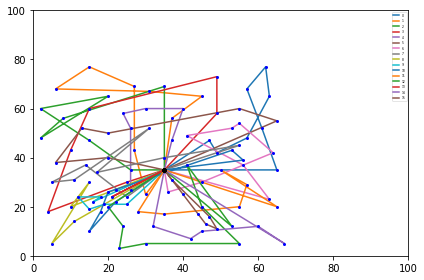

In [32]:
test_dataset = VehicleRoutingDataset1(num_instances,
                                    args.num_nodes,
                                    max_load)
                                    
                                    
test_dir1 = 'test1'
test_loader1 = DataLoader(test_dataset, 1, False, num_workers=0)
out1 = validate(test_loader1, actor, reward, render, test_dir1, num_plot=1
)



print('Average Carbon Emissions (kg) dataset: ',out1)